In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from fitellipse import *

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


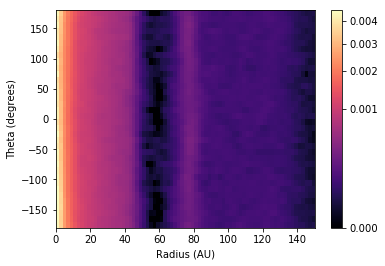

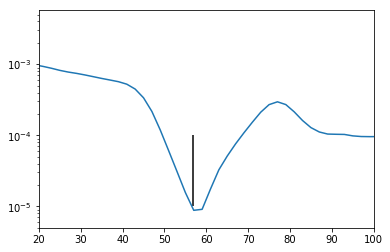

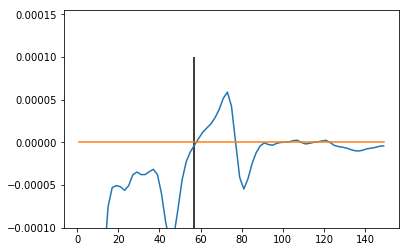

(-5.8215129200779684e-05, 5e-05)

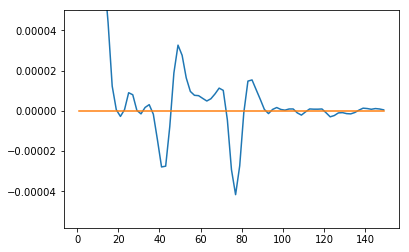

In [38]:
disk = {'filename': '/data/sandrews/jhfiles/LPfiles/taperedimages/Elias24_tapered.image.fits',
                          'distance':136,
                          'incl' : 30.2, 
                          'PA' : 45,
                          'offsetx' : 36.64*.003,
                          'offsety' : -127.75*.003,
                          'size': 3,
                          'gamma': 0.45
                         }

#make some preliminary plots
cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])
    
radialbins = 1+2*np.arange(75)
surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


plt.semilogy(radialbins, surfbrightness)
plt.vlines(56.8, 1.e-5, 1.e-4)
plt.ylim(ymin = 5.e-6)
plt.xlim(xmin =20, xmax = 100)

plt.show()

plt.plot(radialbins, np.gradient(surfbrightness))
plt.plot(radialbins, np.zeros_like(radialbins))
plt.vlines(56.8, -.0001,.0001)
plt.ylim(ymin = -.0001)
plt.show()

plt.plot(radialbins, np.gradient(np.gradient(surfbrightness)))
plt.plot(radialbins, np.zeros_like(radialbins))
plt.ylim(ymax = 5.e-5)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 1.113e-01 arcsec, delta_y = -3.867e-01 arcsec
The MLE semi-major axis is r = 0.564 arcsec
The MLE inclination is i = 29.234 degrees
The MLE position angle is PA = 45.079 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.040e+01


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


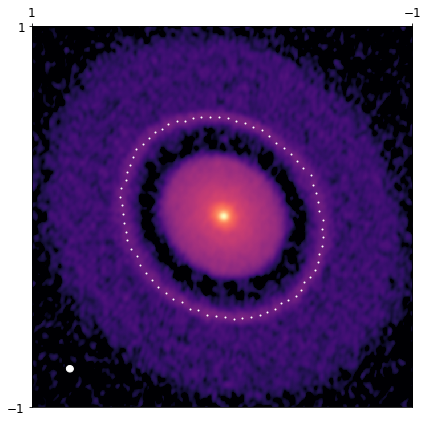

In [3]:
# Extract the ring that's at ~80 AU
xcoords1, ycoords1 = cont.extract_ring(70,90,tbins = -177.5+5*np.arange(72), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     80/140.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)

In [25]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    #flat priors on x0, y0, r0, logvar
    if not (-4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and -15<logvar<-5):
        return -np.inf
    #gaussian prior on PA and cosi based on Dipierro+ 2018
    sig_par = .11
    sig_cosi = .03
    return -((par-0.815)/sig_par)**2-((cosi-0.879)/sig_cosi)**2

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 100
nthreads = 8
nsteps = 1000
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

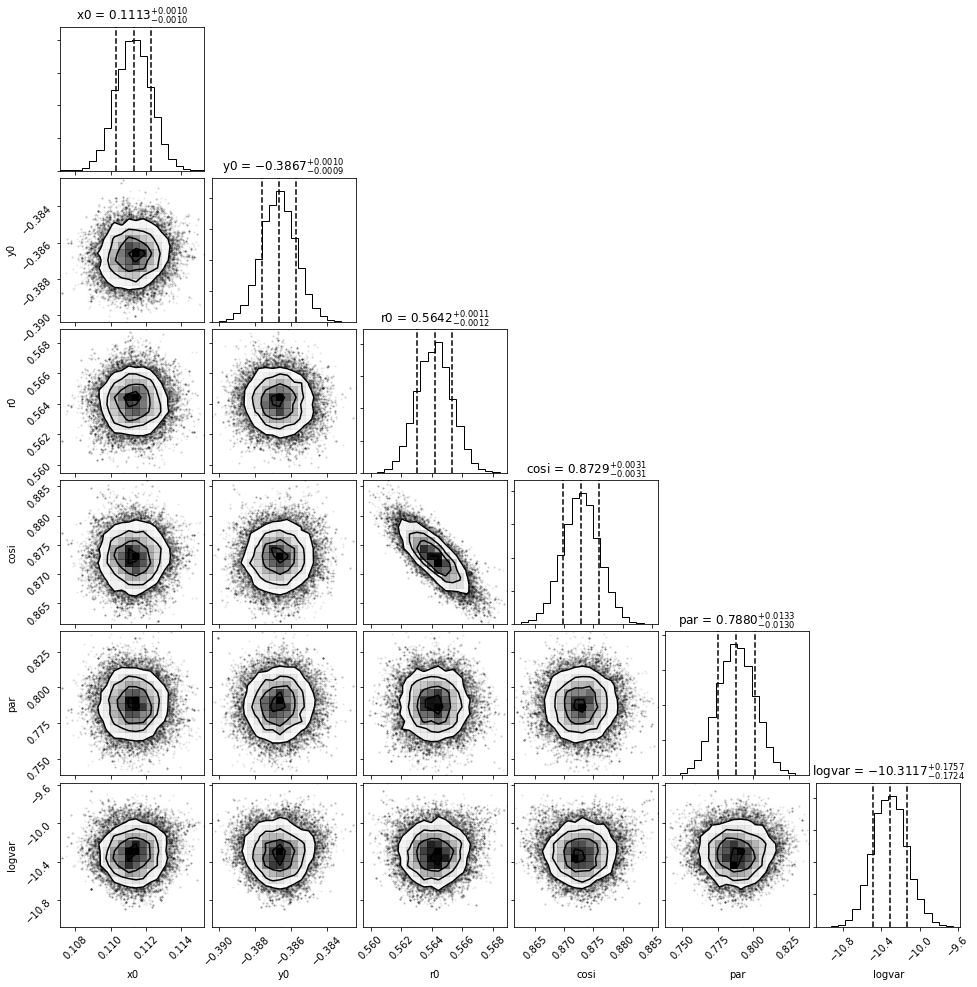

The x offset is delta_x = 1.11e-01 arcsec (+9.9e-04, -1.0e-03)
The y offset is delta_y = -3.87e-01 arcsec (+9.6e-04, -9.5e-04)
The median semi-major axis is r = 0.5642 arcsec (+0.0011, -0.0012) 
or 76.73 AU (+0.13, -0.13)
The incl is i = 29.21 deg (+0.36, -0.36)
The median position angle is PA = 45.15 deg (+0.76, -0.74)
The median log-variance in the pixel offsets from the true ellipse is -1.031e+01


In [26]:

plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)



/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 1.099e-01 arcsec, delta_y = -3.858e-01 arcsec
The MLE semi-major axis is r = 0.418 arcsec
The MLE inclination is i = 27.698 degrees
The MLE position angle is PA = 51.675 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.669e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


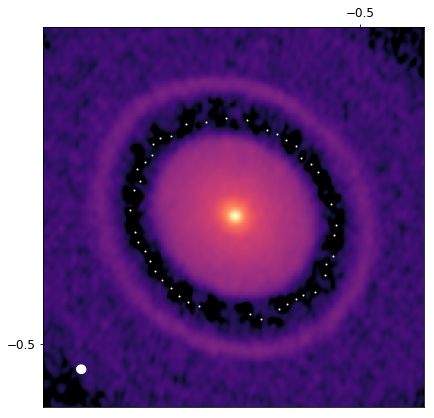

In [32]:
# Extract the gap that's at ~60 AU
xcoords2, ycoords2 = cont.extract_ring(54,60,tbins = -177+6*np.arange(60), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords2, ycoords2, 0.4, 1.5)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_2 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     60/140.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords2, ycoords2)

In [33]:
sampler2 = run_mcmc(nwalkers, nthreads, nsteps, mle_2, lnprob, xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

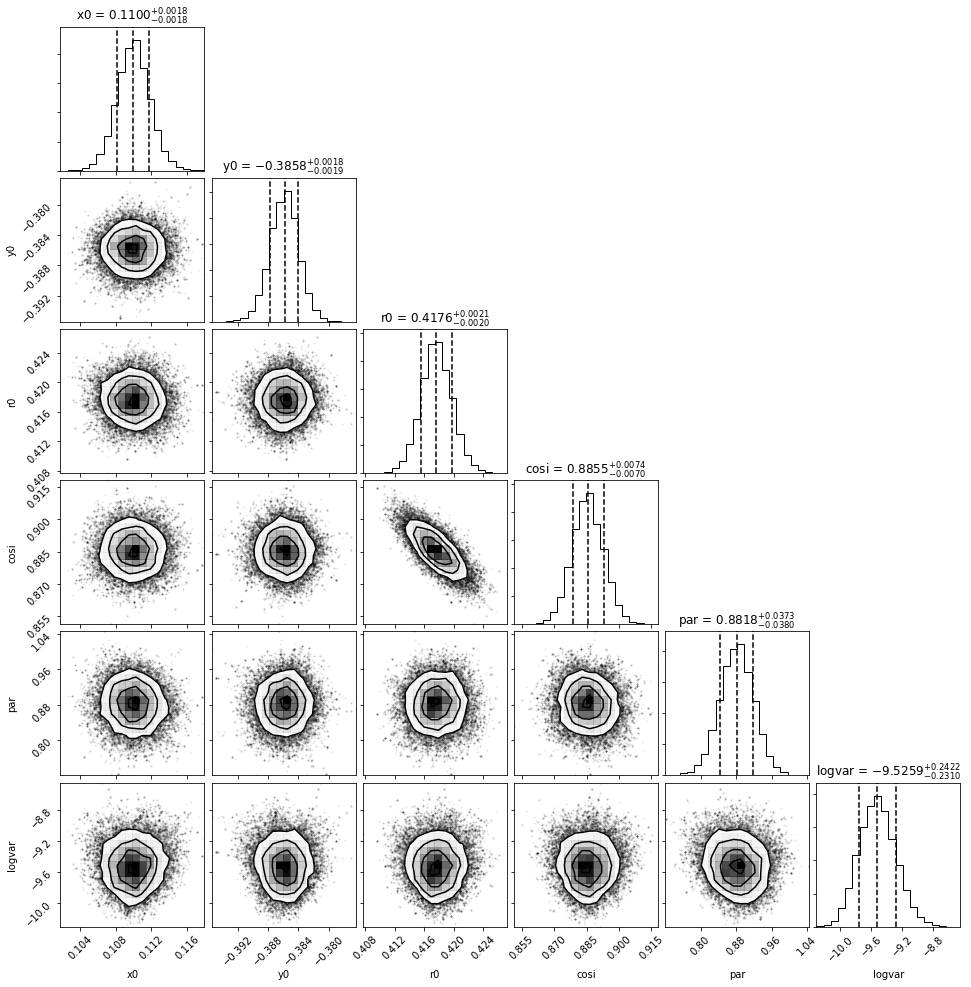

The x offset is delta_x = 1.10e-01 arcsec (+1.8e-03, -1.8e-03)
The y offset is delta_y = -3.86e-01 arcsec (+1.8e-03, -1.9e-03)
The median semi-major axis is r = 0.4176 arcsec (+0.0021, -0.0020) 
or 56.80 AU (+0.25, -0.26)
The incl is i = 27.69 deg (+0.85, -0.92)
The median position angle is PA = 50.53 deg (+2.14, -2.18)
The median log-variance in the pixel offsets from the true ellipse is -9.526e+00


In [34]:

plot_corner(sampler2, 500, 1)
sampler_results(sampler2, 500, cont.src_distance)


In [46]:
radialbins = 0.5+np.arange(0, 150)
#make some preliminary plots
newcont = Continuum(disk['filename'], 0.1105,-0.3865, 45.8, 29,disk['distance'])
    
newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


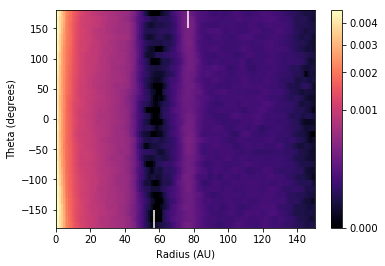

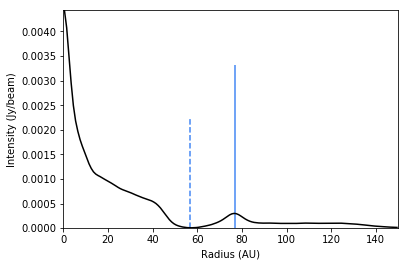

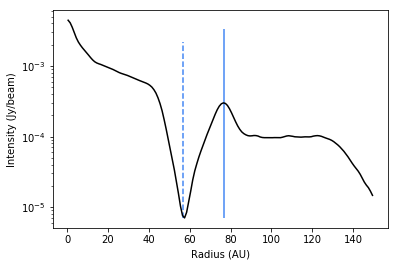

(0, 150)

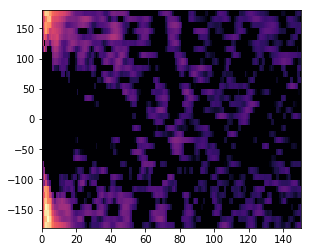

In [47]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)
gaps = np.array([56.8])
rings = np.array([76.7])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = 150)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.mean(newrtmap, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.35, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=150)
plt.xlim(xmin=0, xmax=150)